In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import splitfolders
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.python.client import device_lib
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.python.keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip
from tensorflow.keras.models import Sequential
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam as Adam
from tensorflow.keras.optimizers import SGD as SGD
import shutil
from tensorflow.keras.metrics import MeanIoU
import tensorflow_ranking as tfr
from tensorflow_ranking.python.keras.metrics import MeanAveragePrecisionMetric
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import initializers
import matplotlib.patches as patches
from tensorflow.keras.models import load_model

2022-08-29 03:31:54.145365: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

2022-08-29 03:32:01.886057: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-29 03:32:01.886256: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-29 03:32:01.886813: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-29 03:32:01.976991: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-29 03:32:01.977763: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 na

In [3]:
# input_data_path =r'C:/Users/conm/Desktop/Stenosis-Project/Stenosis detection/input'

train_path = '/home/lunet/conm/Desktop/Stenosis-Project/output/train/stenosis'

# train_path1 = r'C:\Users\conm\Desktop\Stenosis-Project\train_images'

test_path = '/home/lunet/conm/Desktop/Stenosis-Project/test_images'

val_path = '/home/lunet/conm/Desktop/Stenosis-Project/output/val/stenosis'

train_path2 = '/home/lunet/conm/Desktop/Stenosis-Project/output2/train/stenosis'

val_path2 = '/home/lunet/conm/Desktop/Stenosis-Project/output2/val/stenosis'

train_path3 = '/home/lunet/conm/Desktop/Stenosis-Project/output3/train/stenosis'

val_path3 = '/home/lunet/conm/Desktop/Stenosis-Project/output3/val/stenosis'


In [4]:
train_labels_csv = pd.read_csv('train_labels.csv')
train_labels_csv_3 = pd.read_csv('train_labels_3.csv')
len(train_labels_csv_3)

5993

In [5]:
test_labels_csv = pd.read_csv('test_labels.csv')

In [6]:
len(test_labels_csv)

833

In [7]:
val_labels_csv = pd.read_csv('val_labels.csv')
val_labels_csv_2 = pd.read_csv('val_labels_2.csv')
len(val_labels_csv_2)

1499

In [147]:
train_images = []
train_targets = []

val_images = []
val_targets = []

test_images = []
test_targets = []

In [148]:
# Train images to read and resize
# Train labels rescale according to the same size of the train images
for index, row in train_labels_csv_3.iterrows():
    (filename, width, height, class_name, xmin, ymin, xmax, ymax) = row

    pic = cv2.imread(os.path.join(train_path2,filename))
    
    x = pic.shape[0]
    y = pic.shape[1]

    img_Target_size = 224
    x_scale = img_Target_size / x
    y_scale = img_Target_size / y


    pic = cv2.resize(pic, (img_Target_size, img_Target_size))

    # xmin = float(round(xmin * 224))
    # ymin = float(round(ymin * 224))
    # xmax = float(round(xmax * 224))
    # ymax = float(round(ymax * 224))
    x1 = float(np.round(xmin / x_scale, decimals=1))
    y1 = float(np.round(ymin / y_scale, decimals=1))
    x2 = float(np.round(xmax / x_scale, decimals=1))
    y2 = float(np.round(ymax / y_scale, decimals=1))

    # x1 = np.round(float(xmin) / x_scale, decimals=2)
    # y1 = np.round(float(ymin) / y_scale, decimals=2)
    # x2 = np.round(float(xmax) / x_scale, decimals=2)
    # y2 = np.round(float(ymax) / y_scale, decimals=2)

    # xmin /= img_Target_size
    # ymin /= img_Target_size
    # xmax /= img_Target_size
    # ymax /= img_Target_size

    # x1 /= img_Target_size
    # y1 /= img_Target_size
    # x2 /= img_Target_size
    # y2 /= img_Target_size
    
    train_images.append(pic)
    train_targets.append((x1, y1, x2, y2))

In [106]:
# Validation images to read and resize
# Validation labels rescale according to the same size of the validation images
for index, row in val_labels_csv_2.iterrows():
    (filename, width, height, class_name, xmin, ymin, xmax, ymax) = row

    pic = cv2.imread(os.path.join(val_path2,filename))
    
    x = pic.shape[0]
    y = pic.shape[1]
    
    img_Target_size = 224
    x_scale = img_Target_size / x
    y_scale = img_Target_size / y

    pic = cv2.resize(pic, (img_Target_size, img_Target_size))

    # x1 = int(np.round(xmin * x_scale))
    # y1 = int(np.round(ymin * y_scale))
    # x2 = int(np.round(xmax * x_scale))
    # y2 = int(np.round(ymax * y_scale))

    x1 = float(xmin) / x_scale
    y1 = float(ymin) / y_scale
    x2 = float(xmax) / x_scale
    y2 = float(ymax) / y_scale

    # xmin /= img_Target_size
    # ymin /= img_Target_size
    # xmax /= img_Target_size
    # ymax /= img_Target_size
    # xmin = xmin / img_Target_size
    # ymin = ymin / img_Target_size
    # xmax = xmax / img_Target_size
    # ymax = ymax / img_Target_size
    # print(x, y, xmax, ymax)

    val_images.append(pic)
    val_targets.append((x1, y1, x2, y2))

In [107]:
# Test images to read and resize
# Test labels rescale according to the same size of the test images
for index, row in test_labels_csv.iterrows():
    (filename, width, height, class_name, xmin, ymin, xmax, ymax) = row

    pic = cv2.imread(os.path.join(test_path,filename))

    x = pic.shape[0]
    y = pic.shape[1]
    
    img_Target_size = 224
    x_scale = img_Target_size / x
    y_scale = img_Target_size / y

    pic = cv2.resize(pic, (img_Target_size, img_Target_size))
    
    # x1 = int(np.round(xmin * x_scale))
    # y1 = int(np.round(ymin * y_scale))
    # x2 = int(np.round(xmax * x_scale))
    # y2 = int(np.round(ymax * y_scale))

    x1 = float(xmin) / x_scale
    y1 = float(ymin) / y_scale
    x2 = float(xmax) / x_scale
    y2 = float(ymax) / y_scale

    # xmin /= img_Target_size
    # ymin /= img_Target_size
    # xmax /= img_Target_size
    # ymax /= img_Target_size
    # xmin = xmin / img_Target_size
    # ymin = ymin / img_Target_size
    # xmax = xmax / img_Target_size
    # ymax = ymax / img_Target_size
    
    # print(x, y, xmax, ymax)

    test_images.append(pic)
    test_targets.append((x1, y1, x2, y2))

In [108]:
# for index, row in train_labels_csv_3.iterrows():
#     (filename, width, height, class_name, xmin, ymin, xmax, ymax) = row

#     pic = cv2.imread(os.path.join(train_path2,filename))
#     pic = cv2.resize(pic, (224, 224))
    
#     train_images.append(pic)
#     train_targets.append((xmin, ymin, xmax, ymax))

In [109]:
# for index, row in val_labels_csv_2.iterrows():
#     (filename, width, height, class_name, xmin, ymin, xmax, ymax) = row

#     pic = cv2.imread(os.path.join(val_path2,filename))
#     pic = cv2.resize(pic, (224, 224))

#     xmin /= 224
#     ymin /= 224
#     xmax /= 224
#     ymax /= 224
    
#     val_images.append(pic)
#     val_targets.append((xmin, ymin, xmax, ymax))

In [110]:
# for index, row in test_labels_csv.iterrows():
#     (filename, width, height, class_name, xmin, ymin, xmax, ymax) = row

#     pic = cv2.imread(os.path.join(test_path,filename))
#     pic = cv2.resize(pic, (224, 224))

#     xmin /= 224
#     ymin /= 224
#     xmax /= 224
#     ymax /= 224
    
#     test_images.append(pic)
#     test_targets.append((xmin, ymin, xmax, ymax))

In [149]:
train_images = np.array(train_images, dtype='float32') / 255.0
train_targets = np.array(train_targets, dtype='float32')

In [112]:
val_images = np.array(val_images, dtype='float32') / 255.0
val_targets = np.array(val_targets, dtype='float32')

In [113]:
test_images = np.array(test_images, dtype='float32') / 255.0
test_targets = np.array(test_targets, dtype='float32')

In [150]:
train_targets

array([[509.7, 397.7, 548.6, 427.4],
       [493.7, 379.4, 539.4, 422.9],
       [496. , 374.9, 539.4, 406.9],
       ...,
       [340.6, 411.4, 388.6, 484.6],
       [326.9, 372.6, 372.6, 452.6],
       [338.3, 365.7, 374.9, 452.6]], dtype=float32)

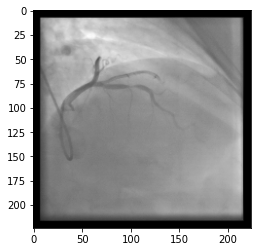

In [146]:
plt.imshow(train_images[0])

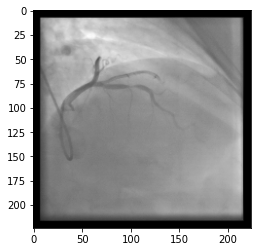

In [151]:
image = cv2.rectangle(train_images[0], (int(train_targets[0][0]),int(train_targets[0][1])), (int(train_targets[0][2]),int(train_targets[0][3])), color=(0,255,0))
plt.imshow((image))

In [133]:
dataGenerator = ImageDataGenerator()

In [134]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [135]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False
# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)
# construct the model we will fine-tune for bounding box regression
model = Model(inputs=vgg.input, outputs=bboxHead)

In [136]:
model.compile(loss="mean_squared_logarithmic_error", optimizer=Adam(learning_rate=0.0001), metrics=[tfr.keras.metrics.MeanAveragePrecisionMetric()])
# print(model.summary())

model_history = model.fit(dataGenerator.flow(train_images, train_targets, batch_size=32),
                            validation_data=(test_images, test_targets), 
                            epochs=250, callbacks=[es], verbose=1, shuffle=True)

Epoch 1/250
 51/188 [=======>......................] - ETA: 6s - loss: 14.2490 - mean_average_precision_metric_1: 1.0000

KeyboardInterrupt: 

In [24]:
model.evaluate(test_images, test_targets)

 3/27 [==>...........................] - ETA: 1s - loss: 13.4904

2022-08-29 03:16:38.040499: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 501559296 exceeds 10% of free system memory.


27/27 [==============================] - 1s 50ms/step - loss: 13.4009


13.4009370803833

In [23]:
# feature_layers = [
#     Conv2D(64, (3, 3), input_shape=(224, 224, 3), padding='same'),
#     LeakyReLU(alpha=0.1),
#     # RandomFlip(mode='horizontal', seed=None),
#     # BatchNormalization(),
#     MaxPool2D(pool_size=(2, 2), padding='same'),

#     Conv2D(64, (3, 3), padding='same'),
#     LeakyReLU(alpha=0.1),
#     BatchNormalization(momentum=0.2),
#     MaxPool2D(pool_size=(2, 2), padding='same'),

#     Conv2D(128, (3, 3), padding='same'),
#     LeakyReLU(alpha=0.1),
#     BatchNormalization(momentum=0.2),
#     MaxPool2D(pool_size=(2, 2), padding='same'),

#     Conv2D(128, (3, 3), padding='same'),
#     LeakyReLU(alpha=0.1),
#     BatchNormalization(momentum=0.2),
#     MaxPool2D(pool_size=(2, 2), padding='same'),

#     # Conv2D(64, (3, 3)),
#     # LeakyReLU(alpha=0.1),
#     # # BatchNormalization(),
#     # MaxPool2D(pool_size=(2, 2), padding='same'),

#     # Conv2D(64, (3, 3), padding='same'),
#     # LeakyReLU(alpha=0.1),
#     # # BatchNormalization(),
#     # MaxPool2D(pool_size=(2, 2), padding='same'),

#     Conv2D(256, (3, 3), padding='same'),
#     LeakyReLU(alpha=0.1),
#     BatchNormalization(momentum=0.2),
#     MaxPool2D(pool_size=(2, 2), padding='same'),

#     # Conv2D(128, (3, 3), padding='same'),
#     # LeakyReLU(alpha=0.1),
#     # # BatchNormalization(),
#     # MaxPool2D(pool_size=(2, 2), padding='same'),

#     # Conv2D(128, (3, 3), padding='same'),
#     # LeakyReLU(alpha=0.1),
#     # # BatchNormalization(),
#     # MaxPool2D(pool_size=(2, 2), padding='same'),

#     # Conv2D(128, (3, 3), padding='same'),
#     # LeakyReLU(alpha=0.1),
#     # # BatchNormalization(),
#     # MaxPool2D(pool_size=(2, 2), padding='same'),

#     # Conv2D(256, (3, 3), padding='same'),
#     # LeakyReLU(alpha=0.1),
#     # # BatchNormalization(),
#     # MaxPool2D(pool_size=(2, 2), padding='same'),

#     # Conv2D(256, (3, 3), padding='same'),
#     # LeakyReLU(alpha=0.1),
#     # BatchNormalization(),
#     # MaxPool2D(pool_size=(2, 2), padding='same'),

#     Conv2D(512, (3, 3), padding='same'),
#     LeakyReLU(alpha=0.1),
#     BatchNormalization(momentum=0.2),
#     MaxPool2D(pool_size=(2, 2), padding='same'),

#     # Conv2D(256, (3, 3), padding='same'),
#     # LeakyReLU(alpha=0.1),
#     # MaxPool2D(pool_size=(2, 2), padding='same'),
# ]

# classification_layers = [
#     Flatten(),
#     Dropout(0.35),
#     Dense(4096, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
#     # LeakyReLU(alpha=0.1),
#     # Dense(2048, kernel_regularizer=regularizers.l2(0.01)),
#     # LeakyReLU(alpha=0.1),
#     # Dense(1024, kernel_regularizer=regularizers.l2(0.01)),
#     # LeakyReLU(alpha=0.1),
#     Dense(1024, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
#     # LeakyReLU(alpha=0.1),
#     Dropout(0.35),
#     Dense(4),
#     Activation('sigmoid')
# ]


In [29]:
model = Sequential()
model.add(Flatten())
model.add(Dense(500, input_shape=(224,224,3), activation= "relu"))
model.add(Dense(100, activation= "relu"))
model.add(Dense(50, activation= "relu"))
model.add(Dense(4, activation= "sigmoid"))

In [33]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

model_history = model.fit(dataGenerator.flow(train_images, train_targets, batch_size=32),
                            validation_data=(test_images, test_targets), 
                            epochs=250, callbacks=[es], verbose=1, shuffle=True)

Epoch 1/250
188/188 [==============================] - 30s 157ms/step - loss: 7810.6431 - accuracy: 0.0000e+00 - val_loss: 7860.7393 - val_accuracy: 0.0000e+00
Epoch 2/250
 52/188 [=======>......................] - ETA: 20s - loss: 7868.1592 - accuracy: 0.0000e+00

KeyboardInterrupt: 

In [154]:
# model = Sequential(feature_layers + classification_layers, name='Stenosis_model')

# # model.compile(optimizer='sgd', loss='mse', metrics=[tfr.keras.metrics.MeanAveragePrecisionMetric()])
# model.compile(loss='mse', optimizer='adam', metrics=[tf.keras.metrics.Precision()])

# model.summary()

Model: "Stenosis_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 224, 224, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 112, 112, 64)      0         
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 64)     256       
 ormalization)                                      

In [ ]:
# keras.backend.clear_session()
# np.random.seed(15)
# tf.random.set_seed(15)

# model_history = model.fit(dataGenerator.flow(train_images, train_targets, batch_size=32),
#                             validation_data=(test_images, test_targets), 
#                             epochs=250, callbacks=[es], verbose=1, shuffle=True)

In [ ]:
model.evaluate(test_images, test_targets, verbose=1, batch_size=32)

11/27 [===========>..................] - ETA: 0s - loss: 0.0100 - mean_average_precision_metric: 0.8999 - mean_io_u: 0.8756

2022-08-22 07:10:20.428948: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 501559296 exceeds 10% of free system memory.


27/27 [==============================] - 9s 361ms/step - loss: 0.0099 - mean_average_precision_metric: 0.8908 - mean_io_u: 0.8687


[0.00989551842212677, 0.890756368637085, 0.8686741590499878]

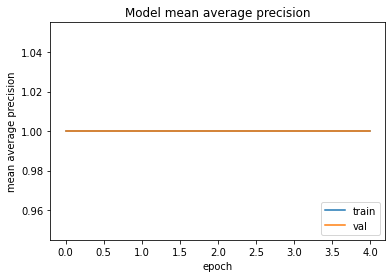

In [36]:
plt.plot(model_history.history['mean_average_precision_metric_1'])
plt.plot(model_history.history['val_mean_average_precision_metric_1'])
plt.title('Model mean average precision')
plt.ylabel('mean average precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

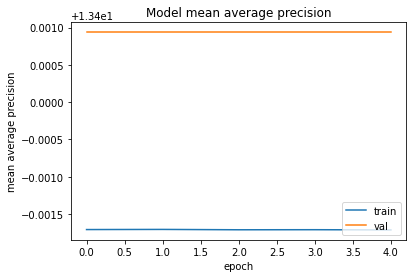

In [37]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model mean average precision')
plt.ylabel('mean average precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [ ]:
for l in feature_layers:
    l.trainable = False

In [ ]:
model_2 = Sequential(feature_layers + classification_layers, name='Stenosis_model_transfer_learning')

In [ ]:
model_2.compile(loss='mse', optimizer=Adam(learning_rate=0.0001), metrics=[tfr.keras.metrics.MeanAveragePrecisionMetric(), tf.keras.metrics.MeanIoU(num_classes=5)])
model_2.summary()


Model: "Stenosis_model_transfer_learning"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 112, 112, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None

In [ ]:
keras.backend.clear_session()
np.random.seed(15)
tf.random.set_seed(15)

model_history2 = model_2.fit(dataGenerator.flow(train_images, train_targets, batch_size=16),
                            validation_data=(val_images, val_targets), 
                            epochs=150, callbacks=[es], verbose=1, shuffle=True)

Epoch 1/150
375/375 [==============================] - ETA: 0s - loss: 0.0139 - mean_average_precision_metric: 0.8930 - mean_io_u: 0.7164

2022-08-22 07:25:37.541048: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 902565888 exceeds 10% of free system memory.


375/375 [==============================] - 12s 10ms/step - loss: 0.0139 - mean_average_precision_metric: 0.8930 - mean_io_u: 0.7161 - val_loss: 0.0089 - val_mean_average_precision_metric: 0.8910 - val_mean_io_u: 0.8372
Epoch 2/150
375/375 [==============================] - 3s 8ms/step - loss: 0.0135 - mean_average_precision_metric: 0.8899 - mean_io_u: 0.7854 - val_loss: 0.0137 - val_mean_average_precision_metric: 0.8912 - val_mean_io_u: 0.7290
Epoch 3/150
375/375 [==============================] - 3s 8ms/step - loss: 0.0137 - mean_average_precision_metric: 0.8876 - mean_io_u: 0.7559 - val_loss: 0.0083 - val_mean_average_precision_metric: 0.8912 - val_mean_io_u: 0.8625
Epoch 4/150
375/375 [==============================] - 3s 8ms/step - loss: 0.0135 - mean_average_precision_metric: 0.8893 - mean_io_u: 0.7635 - val_loss: 0.0087 - val_mean_average_precision_metric: 0.8908 - val_mean_io_u: 0.8541
Epoch 5/150
375/375 [==============================] - 3s 8ms/step - loss: 0.0135 - mean_avera

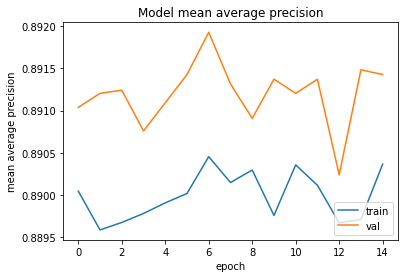

In [ ]:
plt.plot(model_history2.history['mean_average_precision_metric'])
plt.plot(model_history2.history['val_mean_average_precision_metric'])
plt.title('Model mean average precision')
plt.ylabel('mean average precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

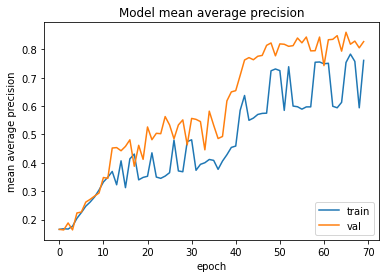

In [ ]:
plt.plot(model_history.history['mean_io_u'])
plt.plot(model_history.history['val_mean_io_u'])
plt.title('Model mean average precision')
plt.ylabel('mean average precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [38]:
model.save('vgg16.h5')

18144 23072 20608 24864
10304 10080 12768 12768
28896 21056 30912 23744
12544 13440 18592 15456
20160 11200 21952 14336


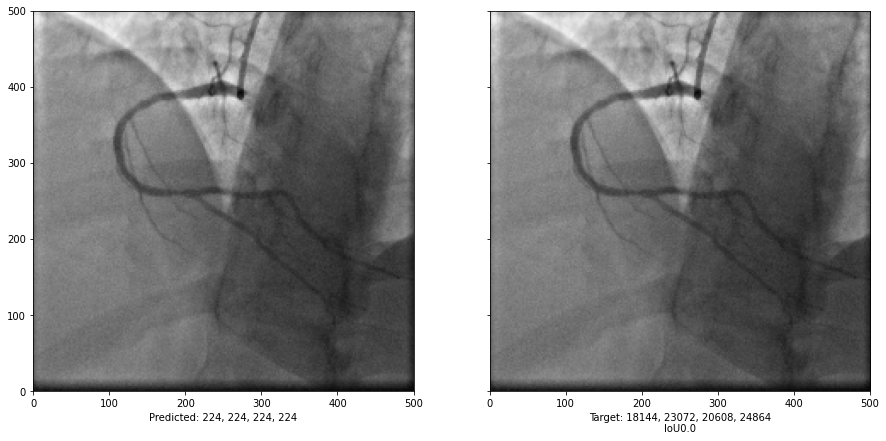

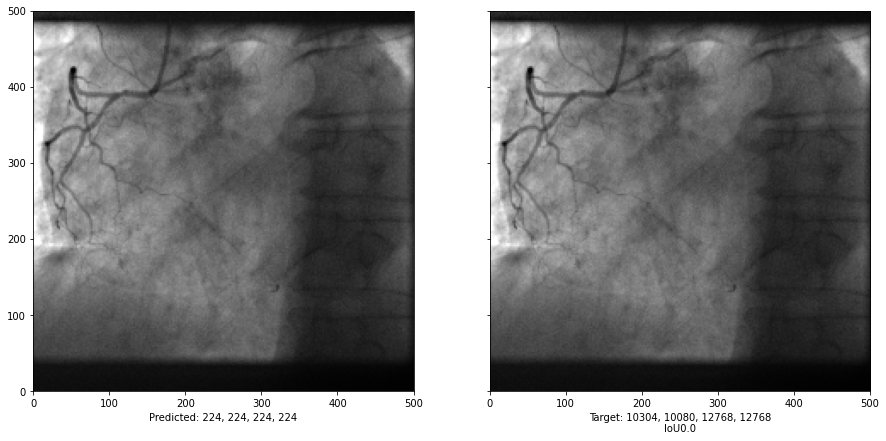

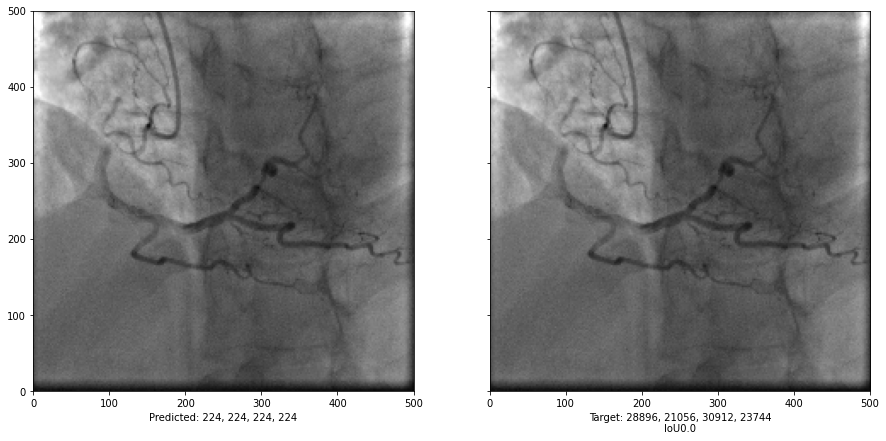

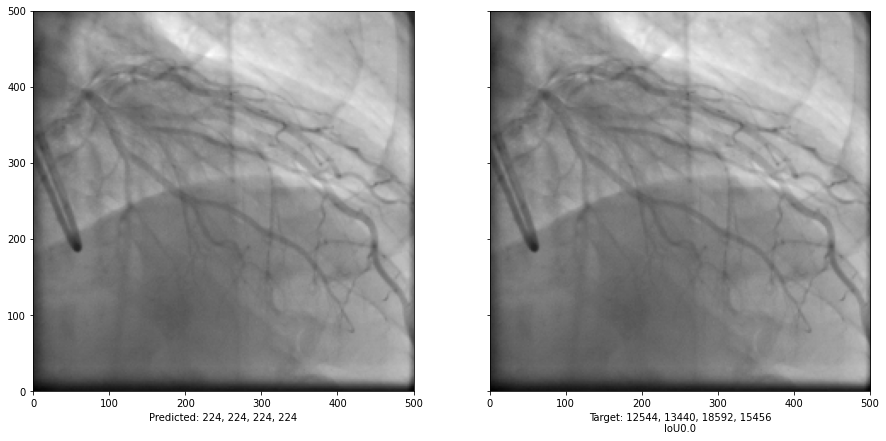

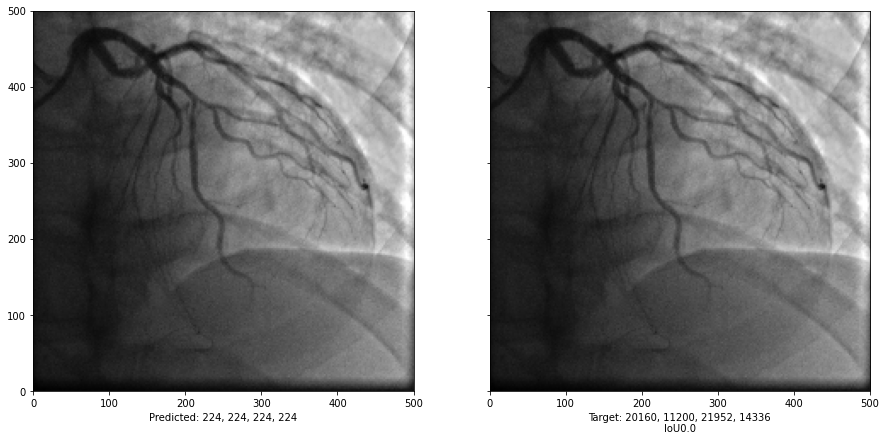

In [39]:
model_load = load_model('vgg16.h5')
# To calculate IoU (intersection over union, given two bounding boxes)
# To calculate IoU (intersection over union, given two bounding boxes)
def bounding_box_intersection_over_union(box_predicted, box_truth):
    # get (x, y) coordinates of intersection of bounding boxes
    top_x_intersect = max(box_predicted[0], box_truth[0])
    top_y_intersect = max(box_predicted[1], box_truth[1])
    bottom_x_intersect = min(box_predicted[2], box_truth[2])
    bottom_y_intersect = min(box_predicted[3], box_truth[3])

    # calculate area of the intersection bb (bounding box)
    intersection_area = max(0, bottom_x_intersect - top_x_intersect + 1) * max(
        0, bottom_y_intersect - top_y_intersect + 1
    )

    # calculate area of the prediction bb and ground-truth bb
    box_predicted_area = (box_predicted[2] - box_predicted[0] + 1) * (
        box_predicted[3] - box_predicted[1] + 1
    )
    box_truth_area = (box_truth[2] - box_truth[0] + 1) * (
        box_truth[3] - box_truth[1] + 1
    )

    # calculate intersection over union by taking intersection
    # area and dividing it by the sum of predicted bb and ground truth
    # bb areas subtracted by  the interesection area

    # return ioU
    return intersection_area / float (
        box_predicted_area + box_truth_area - intersection_area
    )


i, mean_iou = 0, 0

# Compare results for 10 images in the test set
for input_image in test_images[:5]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15), sharey=True, sharex=True)
    im = input_image
    
    # plt.margins(x=0, y=0)

    # Display the image
    ax1.imshow(im, extent=[0,500,0,500])
    ax2.imshow(im, extent=[0,500,0,500])

    input_image = cv2.resize(
        input_image, (224, 224)
    )
    input_image = np.expand_dims(input_image, axis=0)
    preds = model_load.predict(input_image)[0]

    (h, w) = (im).shape[0:2]

    top_left_x, top_left_y = int(preds[0] * w), int(preds[1] * h)

    bottom_right_x, bottom_right_y = int(preds[2] * w), int(preds[3] * h)

    box_predicted = [top_left_x, top_left_y, bottom_right_x, bottom_right_y]
    # Create the bounding box
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    # Add the bounding box to the image
    ax1.add_patch(rect)
    ax1.set_xlabel(
        "Predicted: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
    )

    top_left_x, top_left_y = int(test_targets[i][0] * w), int(test_targets[i][1] * h)

    bottom_right_x, bottom_right_y = int(test_targets[i][2] * w), int(test_targets[i][3] * h)

    box_truth = top_left_x, top_left_y, bottom_right_x, bottom_right_y

    mean_iou += bounding_box_intersection_over_union(box_predicted, box_truth)
    # Create the bounding box
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    # Add the bounding box to the image
    ax2.add_patch(rect)
    # print(top_left_x, top_left_y, bottom_right_x,bottom_right_y)
    ax2.set_xlabel(
        "Target: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
        + "\n"
        + "IoU"
        + str(bounding_box_intersection_over_union(box_predicted, box_truth))
    )
    print(top_left_x, top_left_y, bottom_right_x,bottom_right_y)
    # type(top_left_x)
    i = i + 1
plt.show()

In [ ]:
# pretrained_model = tf.keras.applications.ResNet101(
#         weights='imagenet',
#         include_top=False ,
#         input_shape=(350, 350, 3)
#     )

# pretrained_model.trainable = False
# inputs = keras.Input(shape=(350, 350, 3))
# x = pretrained_model(inputs, training=False)
# # Convert features of shape `base_model.output_shape[1:]` to vectors
# x = keras.layers.GlobalAveragePooling2D()(x)
# # A Dense classifier with a single unit (binary classification)
# outputs = keras.layers.Dense(4)(x)
# model = keras.Model(inputs, outputs)
# # model.load_weights('yolov4.h5')
# # model_0 = tf.keras.Sequential([

# #         pretrained_model,
# #         tf.keras.layers.GlobalAveragePooling2D(),
# #     ])

In [ ]:
# model.compile(loss='mse', optimizer=Adam(learning_rate=0.0001), metrics=[tf.keras.metrics.MeanIoU(num_classes=5), tfr.keras.metrics.MeanAveragePrecisionMetric()])
# model.summary()